### Boosting Weak Classifiers (Decision Stumps)

#### AdaBoost is a method by which we take a weak classifier and construct a distribution over the input data observations. The key is to constantly change the distribution of data on which we train our “weak learner” so that it learns to correct its own mistakes. It runs in $T$ rounds and in each round learns a weak hypothesis $h_t$. It also learns a $coefficient \space \alpha_t$ for each weak hypothesis. The final prediction for an input $x$ is:

<img style="float: l;" src="./images/boosting.png" width="300px">

$$
\begin{aligned}
\hat{y} = sign \big{[} \displaystyle \sum_{t=1}^T \alpha_t h_t (\hat{x}) \big{]} 
\end{aligned}
$$

#### We define a classification algorithm  (the weak learner) $A \big{(} \big{\langle} x_n, y_n, D_n \big{\rangle}_{n=1}^N \big{)} $ that takes as input the training data, training labels, and a weighting vector for each observation. 


                                           
### Environment Setup

In [11]:
import re
import nltk
import numpy as np
import pandas as pd
import pickle as pkl
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import Perceptron
from sklearn.model_selection import KFold
from sklearn.metrics import roc_curve, auc
from nltk.corpus import stopwords
%matplotlib inline 
import matplotlib.pyplot as plt



### Syntatic NLP Processing

#### We will define some Python functions that will perform some syntatic work on our corpus. 

In [12]:
def tokenize(text):
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = [ token for token in tokens if re.search('(^[a-zA-Z]+$)', token) ]
    return filtered_tokens

cachedStopWords = stopwords.words("english") + ['year', 'old', 'man', 'woman', 'ap', 'am', 'pm', 'portable', 'pa', 'lat', 'admitting', 'diagnosis', 'lateral']


### Retrieving our Corpus

#### Let's pull in our corpus that we had serialized out to disk.  

In [13]:
file = open('differential-corpus.pkl','rb')
corpus = pkl.load(file)
file.close()
corpusList = list(corpus.values())
labels = list(corpus.keys())

### Generate Document-Term Frequency Counts

#### In this step we tokenize our text and remove stop words in addition to generating our frequency counts.

#### 1) How many documents are we working with and how many features (unigrams & bigrams)?

#### 2) Can you figure out what max_df and min_df is doing to our feature count?

In [14]:
cv = CountVectorizer(lowercase=True, max_df=0.80, max_features=None, min_df=0.033,
                     ngram_range=(1, 2), preprocessor=None, stop_words=cachedStopWords,
                     strip_accents=None, tokenizer=tokenize, vocabulary=None)
X = cv.fit_transform(corpusList)
print(X.shape)
print()
lexicon = cv.get_feature_names()
print (lexicon)
print()

(1500, 773)

['abd', 'abdomen', 'abdomen contrast', 'abdomen pelvis', 'abdominal', 'abnormalities', 'acquired', 'acute', 'acute sob', 'addition', 'adjacent', 'administered', 'administration', 'adrenal', 'adrenal glands', 'air', 'air space', 'airspace', 'allowing', 'along', 'also', 'also noted', 'although', 'alveolar', 'amount', 'amt', 'amt final', 'amt underlying', 'angle', 'anterior', 'aorta', 'aortic', 'aortic stenosis', 'apex', 'apical', 'apices', 'appear', 'appearance', 'appears', 'approximately', 'approximately cm', 'area', 'areas', 'arrest', 'arteries', 'artery', 'ascites', 'aspect', 'aspiration', 'assess', 'associated', 'atelectasis', 'atelectasis left', 'atrial', 'atrium', 'attenuation', 'available', 'axial', 'axial images', 'axillary', 'base', 'bases', 'basilar', 'bibasilar', 'bilateral', 'bilateral pleural', 'bilateral pulmonary', 'bilaterally', 'bladder', 'bleed', 'blunting', 'bone', 'bone windows', 'bowel', 'breath', 'c', 'ca', 'cabg', 'cad', 'cad chf', 'calcification', 'ca

### Construct our Classes

#### We need to assign a class for each classification. We typically assign numeric values to classes.

In [15]:
Y = []
for key in corpus:        
    if (key.startswith('COPD') or key.startswith('CHF')):
        Y.append(0)
    elif (key.startswith('PNA')):
        Y.append(1)
Y = np.array(Y)

### Let's Run It!

#### We will generate models and evaluate the modes using bootstrapping.

In [16]:
results = []
cont = []
kf = KFold(n_splits=10, shuffle=True)
K = [10, 25, 50, 100, 150, 200, 300]
for k in range(len(K)):
    fold = 1
    truth = []
    bdt_prediction = []
    print("Model ", k, ": Stump Estimators K = " + str(K[k]))
    test_count = 0
    bdt = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1,  criterion="entropy"), algorithm="SAMME", n_estimators=K[k])
    for train_idx, test_idx in kf.split(X):
        trainX = X[train_idx]
        trainY = Y[train_idx]
        testX = X[test_idx]
        testY = Y[test_idx]
        truth.append(testY)
        bdt.fit(trainX, trainY)
        Y_hat = bdt.predict(testX)
        bdt_prediction.append(Y_hat)
        print("   Fold %d accuracy: %.2f %%" % (fold, ((np.sum(Y_hat == testY)/len(testY)) * 100.0)))                        
        fold += 1
    truth = np.concatenate(truth, axis=0)    
    bdt_prediction = np.concatenate(bdt_prediction, axis=0)
    test_results = np.sum(bdt_prediction == truth)/len(truth)
    print("     Overall test accuracy: %.2f %%" % (test_results * 100))  
    bdt = bdt.fit(X, Y)
    Y_hat = bdt.predict(X)
    train_results = np.sum(Y_hat == Y)/len(Y)
    print("     Overall training accuracy: %.2f %%" % (train_results * 100.0))  
    results.append([train_results, test_results])   
    cont.append([truth, bdt_prediction])



Model  0 : Stump Estimators K = 10
   Fold 1 accuracy: 83.33 %
   Fold 2 accuracy: 86.67 %
   Fold 3 accuracy: 84.67 %
   Fold 4 accuracy: 89.33 %
   Fold 5 accuracy: 86.67 %
   Fold 6 accuracy: 84.67 %
   Fold 7 accuracy: 82.00 %
   Fold 8 accuracy: 89.33 %
   Fold 9 accuracy: 84.67 %
   Fold 10 accuracy: 86.67 %
     Overall test accuracy: 85.80 %
     Overall training accuracy: 86.27 %
Model  1 : Stump Estimators K = 25
   Fold 1 accuracy: 91.33 %
   Fold 2 accuracy: 89.33 %
   Fold 3 accuracy: 86.00 %
   Fold 4 accuracy: 90.67 %
   Fold 5 accuracy: 86.67 %
   Fold 6 accuracy: 86.00 %
   Fold 7 accuracy: 92.00 %
   Fold 8 accuracy: 83.33 %
   Fold 9 accuracy: 87.33 %
   Fold 10 accuracy: 88.67 %
     Overall test accuracy: 88.13 %
     Overall training accuracy: 90.07 %
Model  2 : Stump Estimators K = 50
   Fold 1 accuracy: 94.67 %
   Fold 2 accuracy: 84.67 %
   Fold 3 accuracy: 91.33 %
   Fold 4 accuracy: 92.67 %
   Fold 5 accuracy: 93.33 %
   Fold 6 accuracy: 91.33 %
   Fold 7 acc

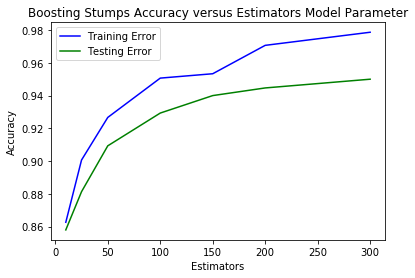

In [17]:
tracc = [item[0] for item in results]
tstacc = [item[1] for item in results]

trainAcc = plt.plot(K, tracc, '-b', label='Training Error')
testACC = plt.plot(K, tstacc, '-g', label='Testing Error')
plt.title("Boosting Stumps Accuracy versus Estimators Model Parameter")
plt.ylabel("Accuracy")
plt.xlabel("Estimators")
plt.legend(loc="best")
plt.show(block=False)

### Contingency Tables

#### Let's look at the contingency tables

#### 1) Can you calculate the Sensitivity, Specificity, PPV, NPV? 

In [18]:
model = input("Enter Best Model: ")
best = cont[int(model)]
bdt_ct = pd.crosstab(best[1], best[0], margins=True)
bdt_ct.columns = ["Other", "PNA", "Total"]
bdt_ct.index = ["Other", "PNA", "Total"]
print()
print("Boosting Decision Stumps")
print(bdt_ct)
print()


Enter Best Model: 2

Boosting Decision Stumps
       Other  PNA  Total
Other    950   86   1036
PNA       50  414    464
Total   1000  500   1500



### Evaluation Statistics

#### We will calculate some test statistics for our classifiers

In [19]:
Sens = bdt_ct.iloc[1][1]/bdt_ct.iloc[2][1]
Spec = bdt_ct.iloc[0][0]/bdt_ct.iloc[2][0]
PPV = bdt_ct.iloc[1][1]/bdt_ct.iloc[1][2]
NPV = bdt_ct.iloc[0][0]/bdt_ct.iloc[0][2]
ACC = (bdt_ct.iloc[0][0] + bdt_ct.iloc[1][1]) / bdt_ct.iloc[2][2]
print("Boosting Decision Stumps: Sensitivity: %.5f Specificity: %.5f PPV: %.5f NPV: %.5f Accuracy: %.5f" % (Sens, Spec, PPV, NPV, ACC))                                                                                      

Boosting Decision Stumps: Sensitivity: 0.82800 Specificity: 0.95000 PPV: 0.89224 NPV: 0.91699 Accuracy: 0.90933


### ROC Curve

#### 1) So which classifier do you think is better?

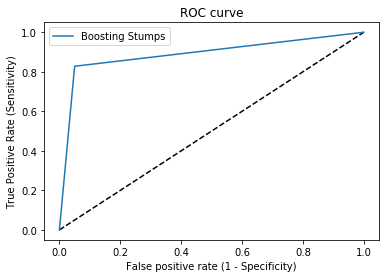

AUC =  0.889


In [20]:
dt_fpr, dt_tpr, dt_thresholds = roc_curve(best[0], best[1], pos_label=1)
roc_auc = auc(dt_fpr, dt_tpr)
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(dt_fpr, dt_tpr, label='Boosting Stumps')
plt.xlabel('False positive rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()
print("AUC = ", roc_auc)